In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [50]:
from sympy import (
    Derivative, 
    S, 
    Symbol, 
    series, 
    sqrt, 
    symbols, 
    oo, 
    limit, 
    Rational, 
    cos, 
    sin, 
    cosh, 
    sinh, 
    Matrix, 
    simplify, 
    latex, 
    lambdify,
    Function,
    collect,
    lambdify,
    solve,
    Eq,
    Poly
)
import numpy as np
import pandas as pd
from sympy import init_printing
init_printing() 

from sympy.printing.latex import print_latex
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib notebook
from pymad_hzb.PlotTools import new_plot_elems_madx
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
from acchamiltoniansandmatrices.Matrices.SymbMatrices import (
    RsymbFODO, 
    RsymbDrift6D, 
    RsymbQuad6D, 
    RsymbQuad6DChroma, 
    RsymbQuad6DThin
)
from acchamiltoniansandmatrices.Matrices.NumpyMatrices import (
    RnpFODO, 
    RnpDrift6D, 
    RnpQuad6D, 
    RnpQuad6DChroma, 
    RnpQuad6DThin
)
from acchamiltoniansandmatrices.Hamiltonians.LatticeElementHamiltonians import (
    HamDrift6D, 
    HamDrift6DParaxialSecondOrder, 
    HamQuad6D, 
    HamQuad6DParaxialSecondOrder, 
    HamQuad6DParaxialSecondOrderChroma,
)
from acchamiltoniansandmatrices.Hamiltonians.Operators import Poisson
from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList, LinMap, GenerateNDimCoordinateGrid
from acchamiltoniansandmatrices.LieMaps.LieOperator import LieOperator
from acchamiltoniansandmatrices.LieMaps.Poisson import PoissonBracket

from acchamiltoniansandmatrices.Utils.JupyterHelpFunctions import hide_toggle
from acchamiltoniansandmatrices.Utils.SymbolicFunctions import SymbolTrick

In [5]:
x, px, y, py, z, delta, eps, h , k0, k1, k2, sigma, betag ,f = symbols('x p_x y p_y z delta epsilon h k_0 k_1 k_2 sigma beta_gamma f', real=True)
L, beta0, gamma0 = symbols(" L beta_0 gamma_0", real=True, positive=True)

# General assumptions

In order to minimize the cluttering of equations the following approximations will be used throughout this notebook:
$$\frac{1}{\beta_0^2\gamma_0^2} \rightarrow 0 \\
\beta_0 \rightarrow 1
$$


# Introduction

Before starting the effective calculations we give a short introduction to the package that takes care of the sympy implementation of the Poisson Bracket and the Lie Operator.

## Defining generic Functions

We start by defining some generic functions where for simplicty we use only $x$ and $px$ as independent variables

In [6]:
A = Function("A", commutative=False)(x,px)
B = Function("B", commutative=False)(x,px)
C = Function("C", commutative=False)(x,px)
D = Function("D", commutative=False)(x,px)
E = Function("E", commutative=False)(x,px)

## Defining Lie Operators

Using the above defined generic functions we can now define the Lie Operators.

In [7]:
Aop = LieOperator(A,x,px)
Bop = LieOperator(B,x,px)
Cop = LieOperator(C,x,px)

In [8]:
Aop

## Basics

Lie operators can be combined, i.e.:
$$e^{:A:}e^{:B:}$$
using the **BCH** method, which is implemented **up to fourth order**.

In [9]:
Aop.BCH(Bop,1)

In [10]:
Aop.BCH(Bop,2)

In [11]:
Aop.BCH(Bop,3)

In [12]:
Aop.BCH(Bop,4)

**Side note on displaying of expressions:**

The package still fails to print the first two arguments without the variables when displaying the Hamiltonian. The underlying cause is that these arguments are not custom defined, like the PoissonBracket, but native sympy objects. Due to this the lowest end of the recursive printing depends on the native implementation for these objects. I did not implement an overloading of these methods yet.

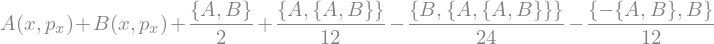

In [13]:
Aop.BCH(Bop,4).ham

## Poisson Brackets

The LieOperator class uses the PoissonBracket class for calculating the brackets. This implementation then accomodates expansion of the brackets, as demonstrated in the examples below.

In [14]:
PoissonBracket(A+B,C)

In [15]:
PoissonBracket(A+B,C).expand(commutator=True)


In [16]:
PoissonBracket(A*B,C)

In [17]:
PoissonBracket(A*B,C).expand(commutator=True)

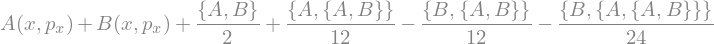

In [18]:
Aop.BCH(Bop,4).ham.expand(commutator=True)

# General

We  start by considering the following lattice:
$$A-B-C$$
where A,B and C are generic lattice elements, **or sublattices**, and we consider the beam coming from the left (this important for the ordering of the operators).

The corresponding Lie map is given by:
$$e^{A}e^{B}e^{C}$$
and after the correct coordinate transformations this becomes:
$$e^{C}e^{B}e^{A}$$

The operators A,B and C in the exponents need to be combined using the BCH formula. Doing this order by order, where with order we mean the number of iterative Poisson brackets and not the order of the resulting polynomial in the independent coordinates, we get:
$$H_0 = A +B + C$$

For the higher orders we go step by step. Let us start by first having a look at $H_1$ for the first three elements.
$$H_1 = A + B + C + \frac{\lbrace \frac{\lbrace A,B \rbrace }{2} + A + B,C \rbrace }{2} + \frac{\lbrace A,B \rbrace }{2}$$


## Using the Package

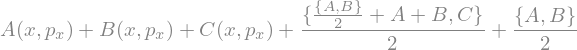

In [19]:
H0 = Aop.BCH(Bop,1).BCH(Cop,1).ham
H1 = Aop.BCH(Bop,2).BCH(Cop,2).ham
H1

Let us clean this up a bit by expanding the Poisson Brackets.

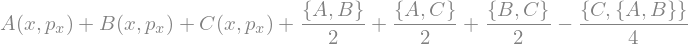

In [20]:
Aop.BCH(Bop,2).BCH(Cop,2).ham.expand(commutator=True)

## Symmetry !

One can immediately see the effect of the BCH formula, making things very complicated very quickly. 

An interesting question to ask is what happens if $C=A$.

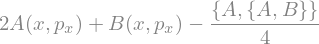

In [21]:
Aop.BCH(Bop,2).BCH(Cop,2).ham.expand(commutator=True).subs(C,A)

**The terms with a single Poisson bracket have been canceled out!**

Let us now break the symmetry lightly and assume that $C = A + \delta A$.

## Explicit Symmetry Breaking

In [22]:
da = Function("\delta A", commutative=False)(x,px)
da

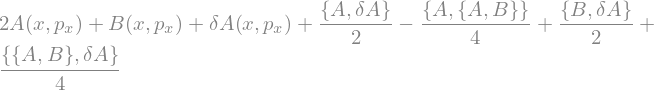

In [23]:
Aop.BCH(Bop,2).BCH(Cop,2).ham.expand(commutator=True).subs(C,A+da).expand(commutator=True)

Slightly breaking the symmetry between the elements $A$ and $C$ immediately introduces new terms
in the Hamiltonian:
$$2 A{\left(x,p_{x} \right)} + B{\left(x,p_{x} \right)} + \delta A{\left(x,p_{x} \right)} + 
\underbrace{\color{blue}{\frac{\lbrace A,\delta A \rbrace }{2}}}_{\color{red}{\text{SB1}}} 
- \frac{\lbrace A,\lbrace A,B \rbrace  \rbrace }{4} 
+ \underbrace{\color{blue}{\frac{\lbrace B,\delta A \rbrace }{2}}}_{\color{red}{\text{SB2}}}  + 
\underbrace{\color{gray}{\frac{\lbrace \lbrace A,B \rbrace ,\delta A \rbrace }{4}}}_{\color{red}{\text{SB3}}} $$
where SB stands for Symmetry Breaking. Note that these terms are directly proportional to the amount of symmetry breaking. 

In [24]:
print_latex(Aop.BCH(Bop,2).BCH(Cop,2).ham.expand(commutator=True).subs(C,A+da).expand(commutator=True))

2 A{\left(x,p_{x} \right)} + B{\left(x,p_{x} \right)} + \delta A{\left(x,p_{x} \right)} + \frac{\lbrace A,\delta A \rbrace }{2} - \frac{\lbrace A,\lbrace A,B \rbrace  \rbrace }{4} + \frac{\lbrace B,\delta A \rbrace }{2} + \frac{\lbrace \lbrace A,B \rbrace ,\delta A \rbrace }{4}


# Explicit Examples

## Example QF-D

### Paraxial Second Order Approximation

In [25]:
# Define constant number symbols in sympy - otherwise they are considered variables
LQ   = SymbolTrick("L_Q")
LD   = SymbolTrick("L_D")
kq1  = SymbolTrick("K_{Q_1}")
dkq1 = SymbolTrick("\delta{K_{Q_1}}")

# inserting replacements to ignore all planes except x-px
rep = list(zip([delta, px, y, py],[0,0,0,0]))

hamq1 = HamQuad6DParaxialSecondOrder(beta0,gamma0,LQ,x,px,y,py,delta,kq1).subs(rep)
hamd  = HamDrift6DParaxialSecondOrder(beta0,gamma0,LD,x,px,y,py,delta).subs(delta,0).subs(py,0)

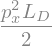

In [26]:
hamd

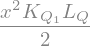

In [28]:
hamq1

### BCH Expansions

In [29]:
qdham1 = Aop.BCH(Bop,1).ham.subs(A,hamq1).subs(B,hamd).doit()
qdham2 = Aop.BCH(Bop,2).ham.subs(A,hamq1).subs(B,hamd).doit()
qdham3 = Aop.BCH(Bop,3).ham.subs(A,hamq1).subs(B,hamd).doit()
qdham4 = Aop.BCH(Bop,4).ham.subs(A,hamq1).subs(B,hamd).doit()

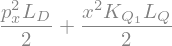

In [30]:
qdham1

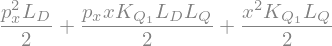

In [32]:
qdham2

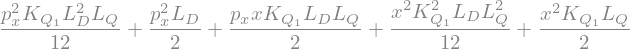

In [33]:
qdham3

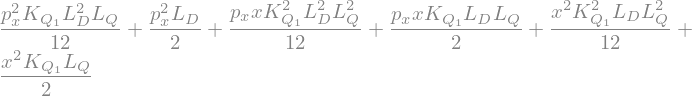

In [34]:
qdham4

### Approximation: First order

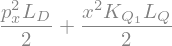

In [35]:
qdham1

**Harmonic Oscillator !!!**

### Approximation: Second order

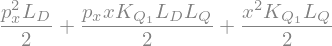

In [36]:
qdham2

Harmonic Oscillator with **mixed** term.

Notice:
$$\frac{p_{x}^{2} L_D}{2} + \frac{p_{x} x {\color{orange}{K_{Q_1}}} {\color{red}{L_D}} {\color{blue}{L_Q}}}{2} + \frac{x^{2} K_{Q_1} L_Q}{2}$$

With
$$ \vert{\color{orange}{K_{Q_1}}}\vert > 1 \\
{\color{red}{L_D}} \gg 1 \\
{\color{blue}{L_Q}} \leq 1
$$

In [37]:
print_latex(qdham2)

\frac{p_{x}^{2} L_D}{2} + \frac{p_{x} x K_{Q_1} L_D L_Q}{2} + \frac{x^{2} K_{Q_1} L_Q}{2}


### Approximation: Third order

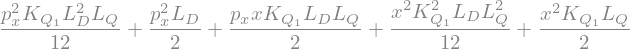

In [38]:
qdham3

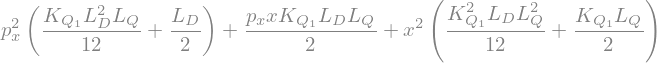

In [39]:
qdham3.collect(x**2).collect(px**2)

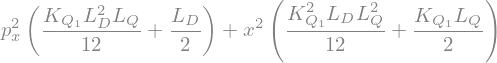

In [82]:
monomlist = Poly(qdham3.collect(x**2).collect(px**2),x,px).monoms()
hoqdham3 = sum([qdham3.collect(x**2).collect(px**2).coeff(x**a*px**b) *x**a*px**b  for a, b in monomlist if a > 1 or b >1]) 
hoqdham3

In [76]:
print_latex(hoqdham3)

p_{x}^{2} \left(\frac{K_{Q_1} L_D^{2} L_Q}{12} + \frac{L_D}{2}\right) + x^{2} \left(\frac{K_{Q_1}^{2} L_D L_Q^{2}}{12} + \frac{K_{Q_1} L_Q}{2}\right)


The Harmonic oscillator part is modified, replacing the drift length $L_{D}$ and the $K_{Q_1}L_Q$ of the quad by some effective values.
$$H^\text{HO}_3 = 
p_{x}^{2} \underbrace{\left(\frac{K_{Q_1} L_D^{2} L_Q}{12} + \frac{L_D}{2}\right)}_{{\color{red}{\text{Effective } L_D}}} + x^{2} \underbrace{\left(\frac{K_{Q_1}^{2} L_D L_Q^{2}}{12} + \frac{K_{Q_1} L_Q}{2}\right)}_{{\color{red}{\text{Effective } K_{Q_1}L_Q}}}$$

In [83]:
ld  = 1
lq  = .25
k =  1.5
nrep = list(zip([LD,LQ,kq1],[ld,lq,k]))
hoqdham1 = lambdify((x,px),qdham1.subs(nrep),"numpy")
hoqdham3 = lambdify((x,px),hoqdham3.subs(nrep),"numpy")

In [87]:
hide_toggle(for_next=True)

<IPython.core.display.Javascript object>


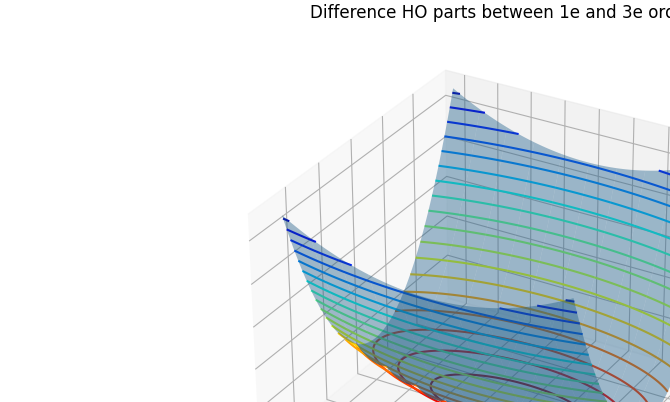

In [89]:

xval = 2.0
pval = 0.9
npoints =100
mg = 50

fig = plt.figure(constrained_layout=True, figsize = (10,6))
gs  = fig.add_gridspec(1, 1)

ax1 = fig.add_subplot(gs[0,0], projection="3d")
X = np.linspace(-xval, xval, npoints)
P = np.linspace(-pval, pval, npoints)
P = np.linspace(-3*pval, 3*pval, npoints)
Xg, Pg = np.meshgrid(X, P)

H = hoqdham3(Xg,Pg) - hoqdham1(Xg,Pg)
ax1.plot_surface(Xg, Pg, H,alpha=0.4,rstride=mg)
ax1 = fig.gca(projection='3d')
cset = ax1.contour(X, P, H,levels=20,cmap=cm.jet_r)
ax1.clabel(cset, fontsize=9, inline=1)
ax1.set_xlabel(r"$x$",fontsize =12);
ax1.set_ylabel(r"$p_x$",fontsize=12);
ax1.set_zlabel(r"$\delta H_{HO}(x,p_x)$",fontsize=12);
ax1.set_title("Difference HO parts between 1e and 3e order");

### Approximation: Fourth order

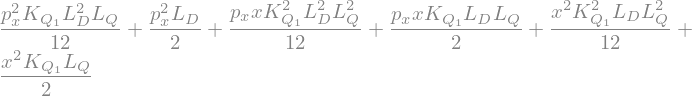

In [90]:
qdham4

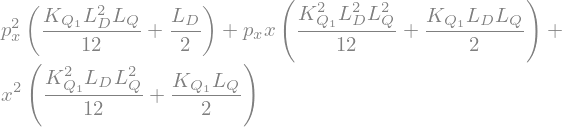

In [92]:
qdham4.collect(x**2).collect(px**2).collect(x*px)

Comparing this last expression with the previous approximation, we observe that the coefficient of the cross-term is updated. A general pattern now seems to emerge where going from up an order in the BCH expansion either corrects the coefficients of the harmonic oscillator part of the *effective* Hamiltonian or the crossterm. In general we are not so worried about the corrections to the Harmonic Oscillator part, as the dynamics of this part will always be an Harmonic Oscillator (exception - single sign change -> unstable motion, ellipses turn into hyperbola). We are more worried about the absolute value of the coefficient of the cross-term. One can ask if increasing denominator can cancel the higher order powers in the numerator, one can ask especially this question in the presence of a long drift space (correction term $L_D^2$).


### Hamiltonian Surfaces comparison

In [141]:
hide_toggle(for_next=True)

<IPython.core.display.Javascript object>


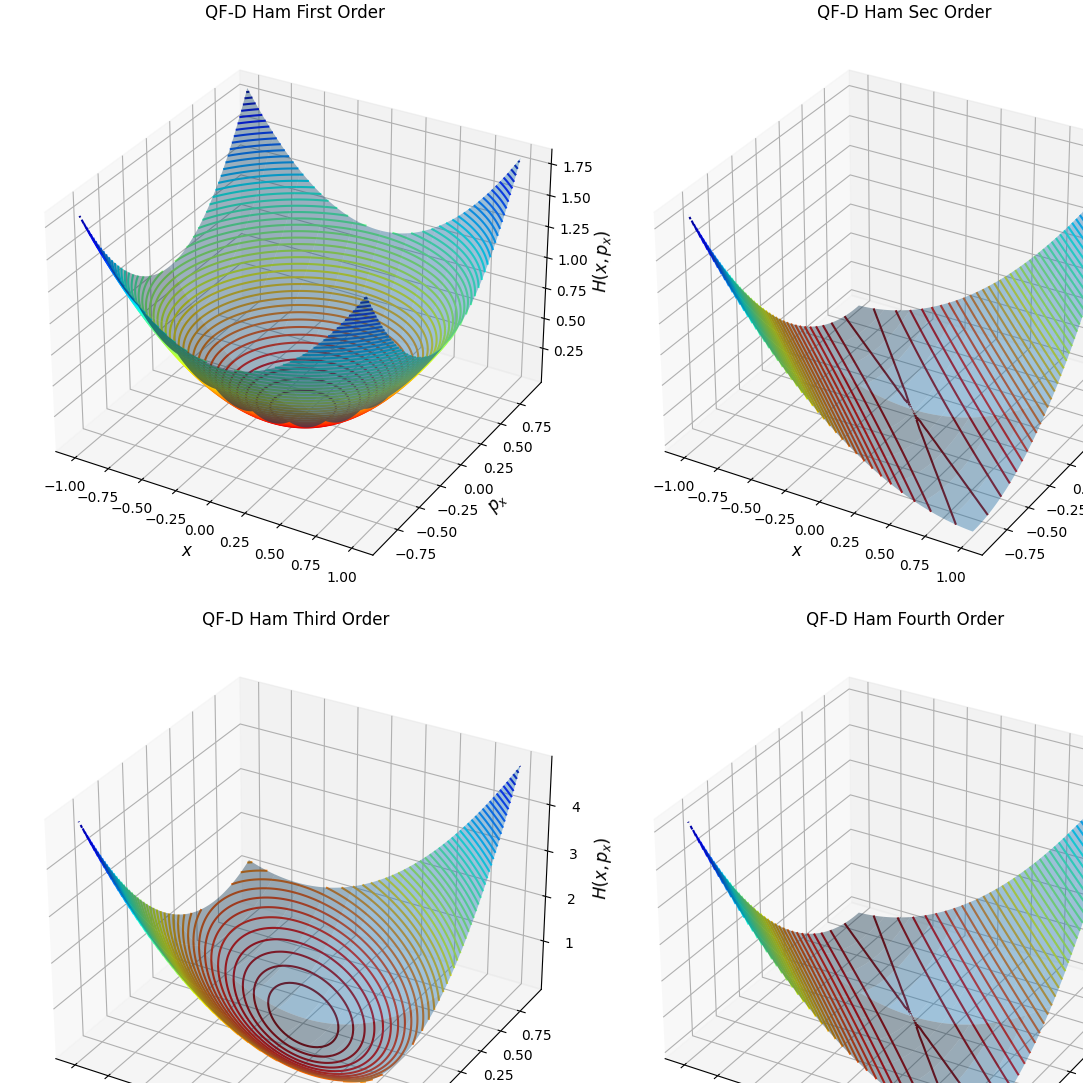

In [139]:
ld  = 2.35
lq  = .25
k =  7.
nrep = list(zip([LD,LQ,kq1],[ld,lq,k]))

hoqdham1 = lambdify((x,px),qdham1.subs(nrep),"numpy")
hoqdham2 = lambdify((x,px),qdham2.subs(nrep),"numpy")
hoqdham3 = lambdify((x,px),qdham3.subs(nrep),"numpy")
hoqdham4 = lambdify((x,px),qdham4.subs(nrep),"numpy")

xval = 1.0
pval = 0.9
npoints =100
mg = 50

X = np.linspace(-xval, xval, npoints)
P = np.linspace(-pval, pval, npoints)
Xg, Pg = np.meshgrid(X, P)

H1 = hoqdham1(Xg,Pg)
H2 = hoqdham2(Xg,Pg)
H3 = hoqdham3(Xg,Pg)
H4 = hoqdham4(Xg,Pg)

n=21 #number of energy levels to show +1 

color=cm.jet(np.linspace(1,0,n))

# subplot grid
fig = plt.figure(constrained_layout=True, figsize = (12,12))
gs  = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0,0], projection = "3d")
ax2 = fig.add_subplot(gs[0,1], projection = "3d")
ax3 = fig.add_subplot(gs[1,0], projection = "3d")
ax4 = fig.add_subplot(gs[1,1], projection = "3d")

hams = [H1,H2,H3,H4]
axs  = [ax1,ax2,ax3,ax4]
title = ["QF-D Ham First Order","QF-D Ham Sec Order","QF-D Ham Third Order","QF-D Ham Fourth Order"]

for h,a,t in zip(hams,axs,title):
    a.plot_surface(Xg, Pg, h,alpha=0.4,rstride=mg)
    cset = a.contour(X, P, h,levels=mg,cmap=cm.jet_r)
    a.clabel(cset, fontsize=9, inline=1)
    a.set_xlabel(r"$x$",fontsize =12);
    a.set_ylabel(r"$p_x$",fontsize=12);
    a.set_zlabel(r"$H(x,p_x)$",fontsize=12);
    a.set_title(t)



In [145]:
hide_toggle(for_next=True)

<IPython.core.display.Javascript object>


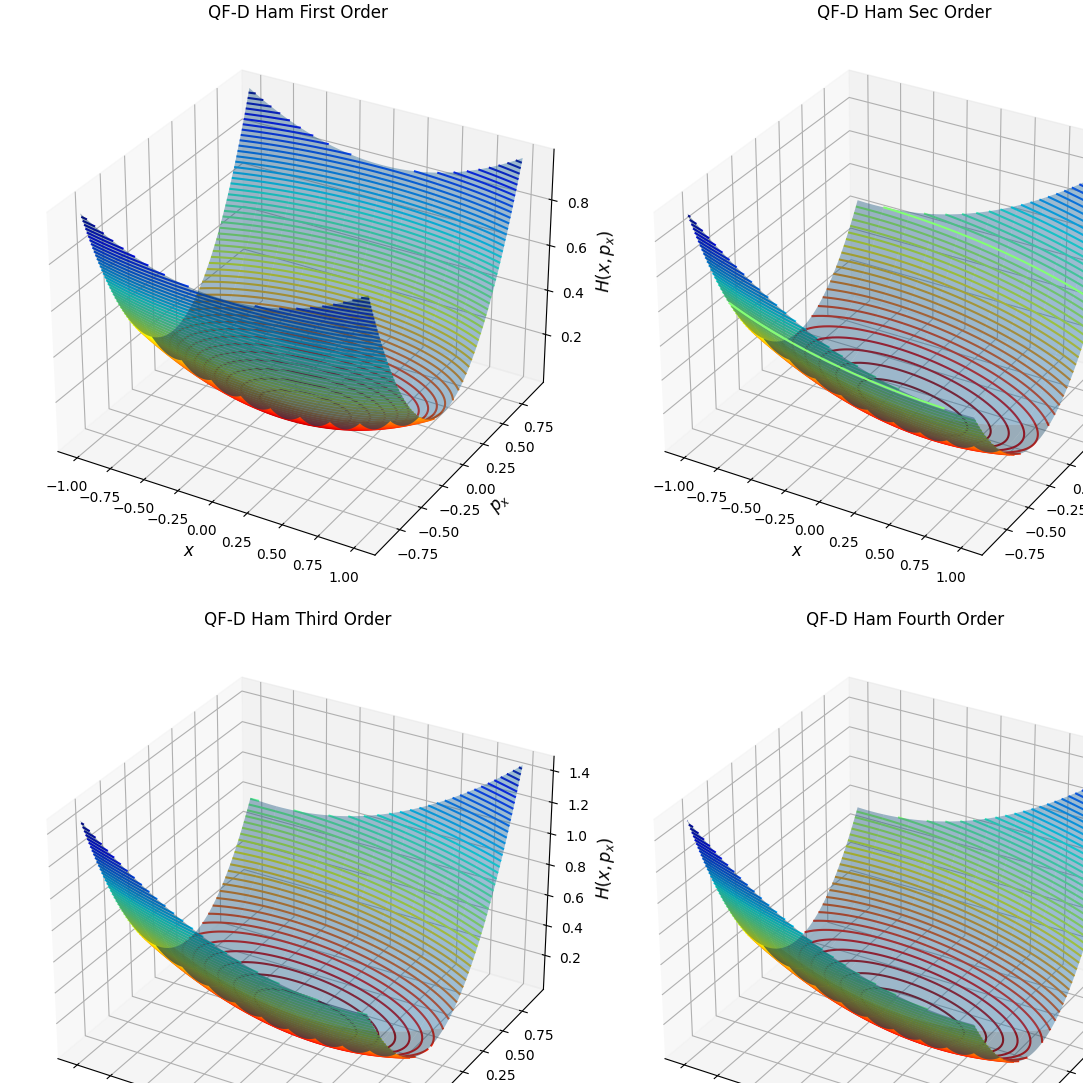

In [144]:
ld  = 2
lq  = .25
k =  1.5
nrep = list(zip([LD,LQ,kq1],[ld,lq,k]))

hoqdham1 = lambdify((x,px),qdham1.subs(nrep),"numpy")
hoqdham2 = lambdify((x,px),qdham2.subs(nrep),"numpy")
hoqdham3 = lambdify((x,px),qdham3.subs(nrep),"numpy")
hoqdham4 = lambdify((x,px),qdham4.subs(nrep),"numpy")

xval = 1.0
pval = 0.9
npoints =100
mg = 50

X = np.linspace(-xval, xval, npoints)
P = np.linspace(-pval, pval, npoints)
Xg, Pg = np.meshgrid(X, P)

H1 = hoqdham1(Xg,Pg)
H2 = hoqdham2(Xg,Pg)
H3 = hoqdham3(Xg,Pg)
H4 = hoqdham4(Xg,Pg)

n=21 #number of energy levels to show +1 

color=cm.jet(np.linspace(1,0,n))

# subplot grid
fig = plt.figure(constrained_layout=True, figsize = (12,12))
gs  = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0,0], projection = "3d")
ax2 = fig.add_subplot(gs[0,1], projection = "3d")
ax3 = fig.add_subplot(gs[1,0], projection = "3d")
ax4 = fig.add_subplot(gs[1,1], projection = "3d")

hams = [H1,H2,H3,H4]
axs  = [ax1,ax2,ax3,ax4]
title = ["QF-D Ham First Order","QF-D Ham Sec Order","QF-D Ham Third Order","QF-D Ham Fourth Order"]

for h,a,t in zip(hams,axs,title):
    a.plot_surface(Xg, Pg, h,alpha=0.4,rstride=mg)
    cset = a.contour(X, P, h,levels=mg,cmap=cm.jet_r)
    a.clabel(cset, fontsize=9, inline=1)
    a.set_xlabel(r"$x$",fontsize =12);
    a.set_ylabel(r"$p_x$",fontsize=12);
    a.set_zlabel(r"$H(x,p_x)$",fontsize=12);
    a.set_title(t)



### Important message

* Asymmetric lattice
* Expansion to different orders shows different dynamics!
* Emergence of instabilities for certain values

### Using full Hamiltonian for the drift

In [151]:
# Define constant number symbols in sympy - otherwise they are considered variables
LQ   = SymbolTrick("L_Q")
LD   = SymbolTrick("L_D")
kq1  = SymbolTrick("K_{Q_1}")
dkq1 = SymbolTrick("\delta{K_{Q_1}}")

# inserting replacements to ignore all planes except x-px
rep = list(zip([delta, px, y, py],[0,0,0,0]))

hamq1 = HamQuad6DParaxialSecondOrder(beta0,gamma0,LQ,x,px,y,py,delta,kq1).subs(rep)
hamd0  = HamDrift6D(beta0,gamma0,LD,x,px,y,py,delta).subs(delta,0).subs(py,0)
hamd  = hamd0.subs(beta0*gamma0,oo).subs(beta0,1)

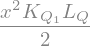

In [152]:
hamq1

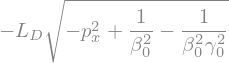

In [153]:
hamd0

In [154]:
hamd

### BCH Expansions

In [155]:
qdham1f = Aop.BCH(Bop,1).ham.subs(A,hamq1).subs(B,hamd).doit()
qdham2f = Aop.BCH(Bop,2).ham.subs(A,hamq1).subs(B,hamd).doit()
qdham3f = Aop.BCH(Bop,3).ham.subs(A,hamq1).subs(B,hamd).doit()
qdham4f = Aop.BCH(Bop,4).ham.subs(A,hamq1).subs(B,hamd).doit()

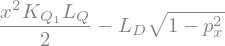

In [156]:
qdham1f

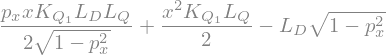

In [157]:
qdham2f

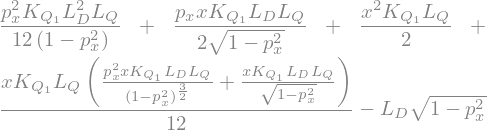

In [158]:
qdham3f

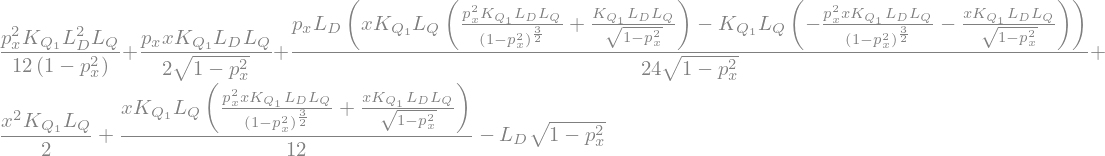

In [159]:
qdham4f

### Hamiltonian Surfaces comparison

In [164]:
hide_toggle(for_next=True)

<IPython.core.display.Javascript object>


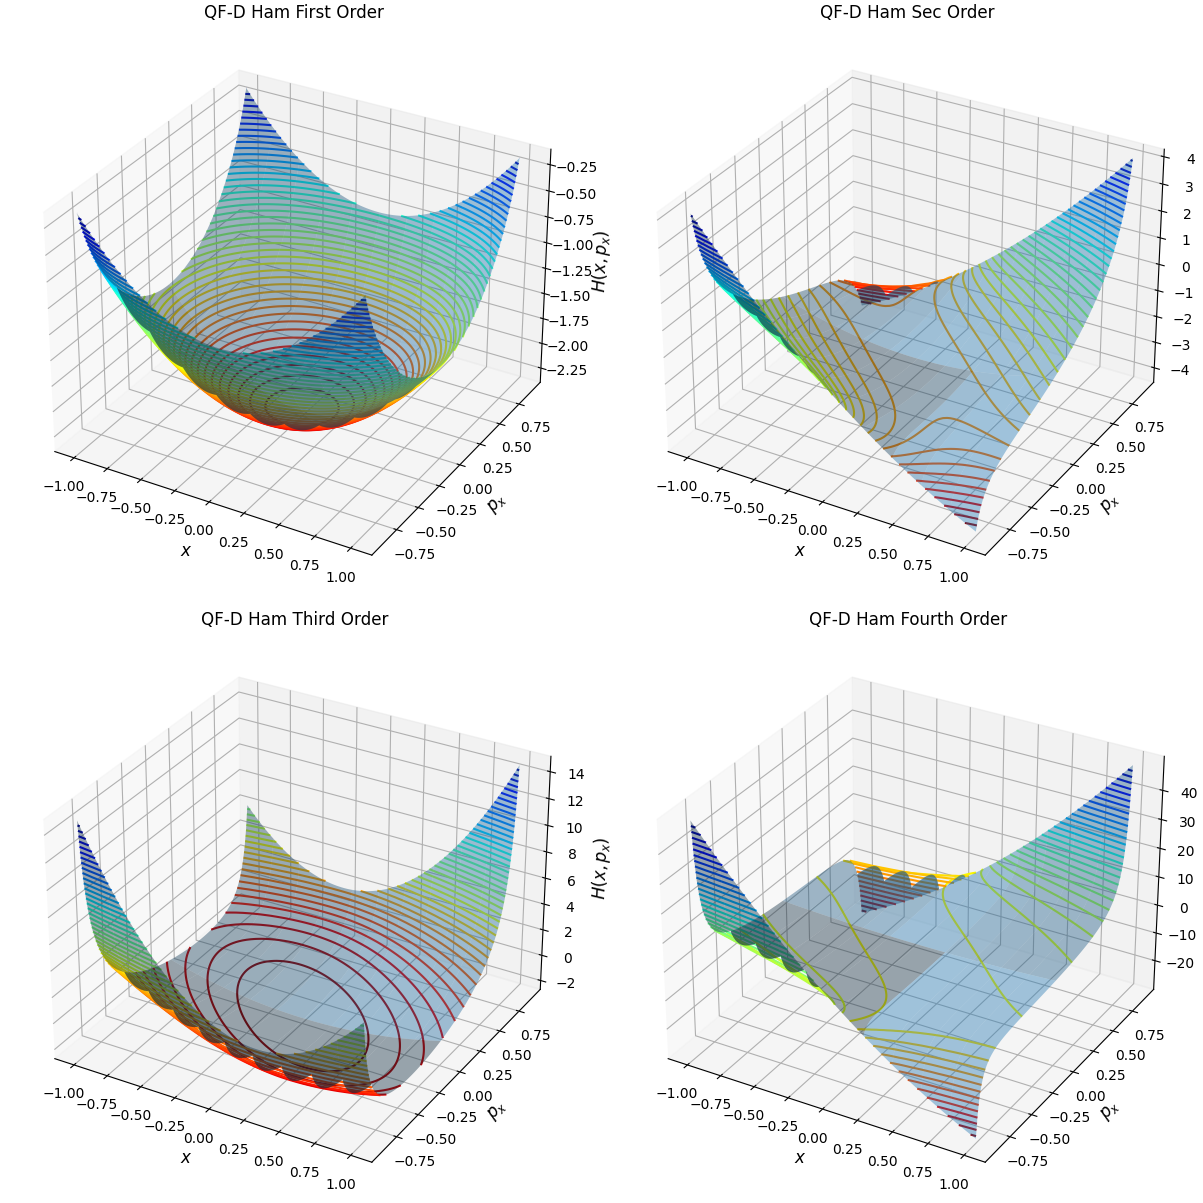

In [163]:
ld  = 2.35
lq  = .25
k =  7.
nrep = list(zip([LD,LQ,kq1],[ld,lq,k]))

hoqdham1 = lambdify((x,px),qdham1f.subs(nrep),"numpy")
hoqdham2 = lambdify((x,px),qdham2f.subs(nrep),"numpy")
hoqdham3 = lambdify((x,px),qdham3f.subs(nrep),"numpy")
hoqdham4 = lambdify((x,px),qdham4f.subs(nrep),"numpy")

xval = 1.0
pval = 0.9
npoints =100
mg = 50

X = np.linspace(-xval, xval, npoints)
P = np.linspace(-pval, pval, npoints)
Xg, Pg = np.meshgrid(X, P)

H1 = hoqdham1(Xg,Pg)
H2 = hoqdham2(Xg,Pg)
H3 = hoqdham3(Xg,Pg)
H4 = hoqdham4(Xg,Pg)

n=21 #number of energy levels to show +1 

color=cm.jet(np.linspace(1,0,n))

# subplot grid
fig = plt.figure(constrained_layout=True, figsize = (12,12))
gs  = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0,0], projection = "3d")
ax2 = fig.add_subplot(gs[0,1], projection = "3d")
ax3 = fig.add_subplot(gs[1,0], projection = "3d")
ax4 = fig.add_subplot(gs[1,1], projection = "3d")

hams = [H1,H2,H3,H4]
axs  = [ax1,ax2,ax3,ax4]
title = ["QF-D Ham First Order","QF-D Ham Sec Order","QF-D Ham Third Order","QF-D Ham Fourth Order"]

for h,a,t in zip(hams,axs,title):
    a.plot_surface(Xg, Pg, h,alpha=0.4,rstride=mg)
    cset = a.contour(X, P, h,levels=mg,cmap=cm.jet_r)
    a.clabel(cset, fontsize=9, inline=1)
    a.set_xlabel(r"$x$",fontsize =12);
    a.set_ylabel(r"$p_x$",fontsize=12);
    a.set_zlabel(r"$H(x,p_x)$",fontsize=12);
    a.set_title(t)



In [162]:
hide_toggle(for_next=True)

<IPython.core.display.Javascript object>


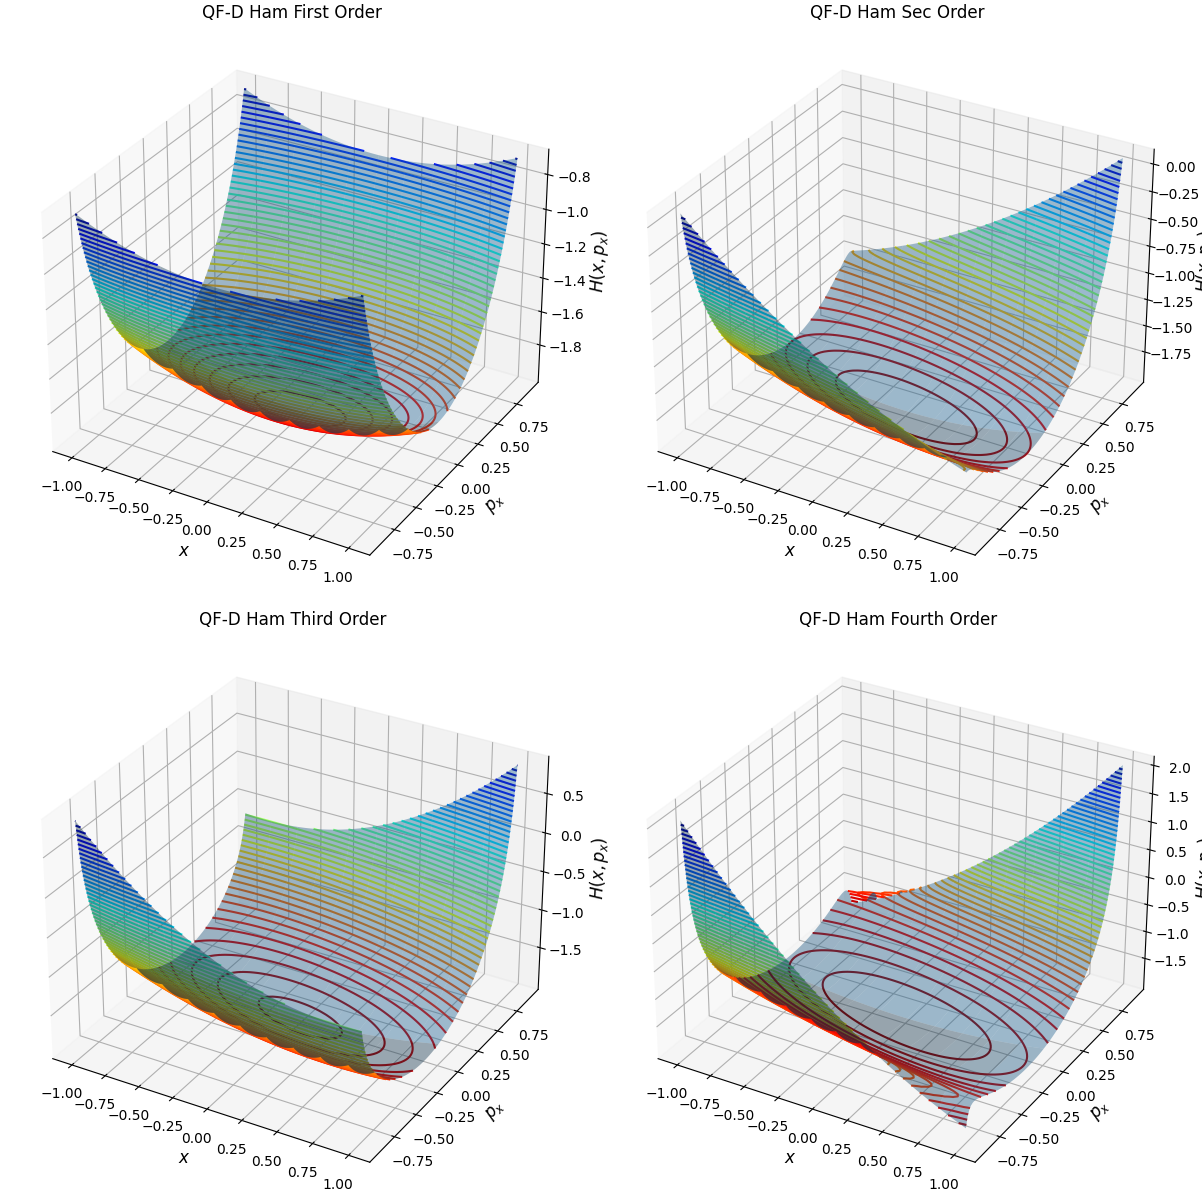

In [161]:
ld  = 2
lq  = .25
k =  1.5
nrep = list(zip([LD,LQ,kq1],[ld,lq,k]))

hoqdham1 = lambdify((x,px),qdham1f.subs(nrep),"numpy")
hoqdham2 = lambdify((x,px),qdham2f.subs(nrep),"numpy")
hoqdham3 = lambdify((x,px),qdham3f.subs(nrep),"numpy")
hoqdham4 = lambdify((x,px),qdham4f.subs(nrep),"numpy")

xval = 1.0
pval = 0.9
npoints =100
mg = 50

X = np.linspace(-xval, xval, npoints)
P = np.linspace(-pval, pval, npoints)
Xg, Pg = np.meshgrid(X, P)

H1 = hoqdham1(Xg,Pg)
H2 = hoqdham2(Xg,Pg)
H3 = hoqdham3(Xg,Pg)
H4 = hoqdham4(Xg,Pg)

n=21 #number of energy levels to show +1 

color=cm.jet(np.linspace(1,0,n))

# subplot grid
fig = plt.figure(constrained_layout=True, figsize = (12,12))
gs  = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0,0], projection = "3d")
ax2 = fig.add_subplot(gs[0,1], projection = "3d")
ax3 = fig.add_subplot(gs[1,0], projection = "3d")
ax4 = fig.add_subplot(gs[1,1], projection = "3d")

hams = [H1,H2,H3,H4]
axs  = [ax1,ax2,ax3,ax4]
title = ["QF-D Ham First Order","QF-D Ham Sec Order","QF-D Ham Third Order","QF-D Ham Fourth Order"]

for h,a,t in zip(hams,axs,title):
    a.plot_surface(Xg, Pg, h,alpha=0.4,rstride=mg)
    cset = a.contour(X, P, h,levels=mg,cmap=cm.jet_r)
    a.clabel(cset, fontsize=9, inline=1)
    a.set_xlabel(r"$x$",fontsize =12);
    a.set_ylabel(r"$p_x$",fontsize=12);
    a.set_zlabel(r"$H(x,p_x)$",fontsize=12);
    a.set_title(t)



## Example QF-D-QF

In [146]:
# Define constant number symbols in sympy - otherwise they are considered variables
LQ   = SymbolTrick("L_Q")
LD   = SymbolTrick("L_D")
kq1  = SymbolTrick("K_{Q_1}")
dkq1 = SymbolTrick("\delta{K_{Q_1}}")

# inserting replacements to ignore all planes except x-px
rep = list(zip([delta, px, y, py],[0,0,0,0]))

hamq1 = HamQuad6DParaxialSecondOrder(beta0,gamma0,LQ,x,px,y,py,delta,kq1).subs(rep)
hamq2 = HamQuad6DParaxialSecondOrder(beta0,gamma0,LQ,x,px,y,py,delta,kq1+dkq1).subs(rep)
hamd  = HamDrift6DParaxialSecondOrder(beta0,gamma0,LD,x,px,y,py,delta).subs(delta,0).subs(py,0)

In [147]:
qdqham1 = Aop.BCH(Bop,1).BCH(Aop,1).ham.subs(A,hamq1).subs(B,hamd).doit()
qdqham2 = Aop.BCH(Bop,2).BCH(Aop,2).ham.subs(A,hamq1).subs(B,hamd).doit()
qdqham3 = Aop.BCH(Bop,3).BCH(Aop,3).ham.subs(A,hamq1).subs(B,hamd).doit()
qdqham4 = Aop.BCH(Bop,4).BCH(Aop,4).ham.subs(A,hamq1).subs(B,hamd).doit()

In [24]:
qdham2 = Aop.BCH(Bop,2).BCH(Aop,2).ham.subs(A,hamq1).subs(B,hamd).doit()
qdham2 = Aop.BCH(Bop,2).BCH(Aop,2).ham.subs(A,hamq1).subs(B,hamd).doit()

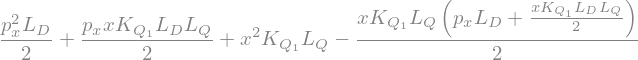

In [25]:
qdham

In [26]:
k=1.5
lq = .25
ld = 2
dk = .1
nrep = list(zip([LD,LQ,kq1],[ld,lq,k]))
qd_ham = qdham.subs(nrep)
qd_ham

<IPython.core.display.Javascript object>


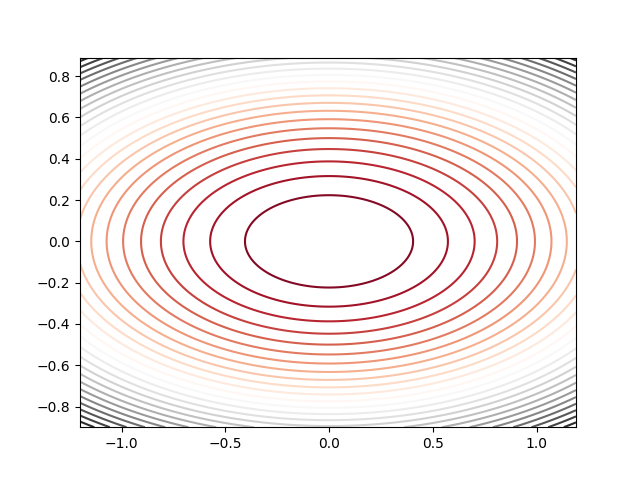

In [27]:
fig = plt.figure()
valx = 1.2
valpx = 0.9
xx = np.arange(-valx, valx, 0.01)
pxp = np.arange(-valpx, valpx, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),qd_ham,"numpy")
H = ham(X, P)

plt.contour(X,P,H, 30, cmap='RdGy')
plt.show()

In [28]:
# inserting replacements to ignore all planes besides x-px
rep = list(zip([delta, px, y, py],[0,0,0,0]))
hamq1 = HamQuad6DParaxialSecondOrder(beta0,gamma0,LQ,x,px,y,py,delta,kq1).subs(rep)
hamd  = HamDrift6D(beta0,gamma0,LD,x,px,y,py,delta).subs(delta,0).subs(py,0)

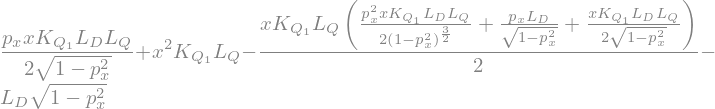

In [29]:
qdhamf = Aop.BCH(Bop,2).BCH(Aop,2).ham.subs(A,hamq1).subs(B,hamd).doit().subs(beta0*gamma0,oo).subs(beta0,1)
qdhamf

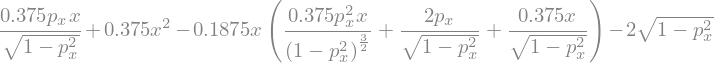

In [30]:
k=1.5
lq = .25
ld = 2
dk = -.5
nrep = list(zip([LD,LQ,kq1],[ld,lq,k]))
qd_hamf = qdhamf.subs(nrep)
qd_hamf

<IPython.core.display.Javascript object>


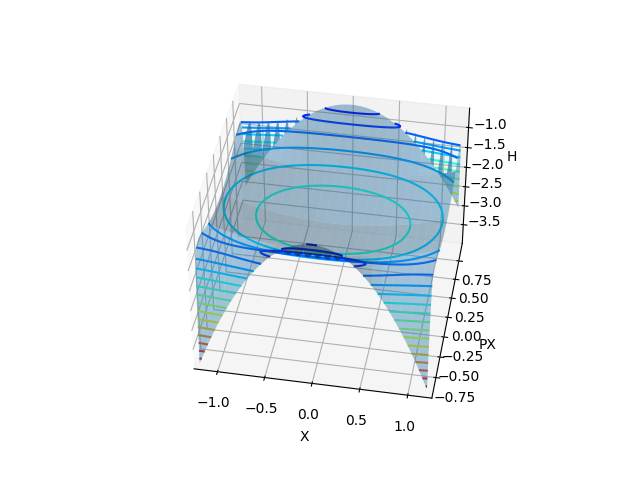

In [31]:

mg  = 50   # meshgrid size

fig = plt.figure()
ax = fig.gca(projection='3d')
valx = 1.2
valpx = 0.955
xx = np.arange(-valx, valx, 0.01)
pxp = np.arange(-valpx, valpx, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),qd_hamf,"numpy")
H = ham(X, P)

ax.plot_surface(X, P, H,alpha=0.4,rstride=mg)
cset = ax.contour(X, P, H,levels=20,cmap=cm.jet_r)
ax.clabel(cset, fontsize=9, inline=1)

ax.set_xlabel('X')
ax.set_xlim(-valx, valx)
ax.set_ylabel('PX')
ax.set_ylim(-valpx, valpx)
ax.set_zlabel('H')
#ax.set_zlim(-100, 100)
ax.view_init(elev=40., azim=-80)
plt.show()

<IPython.core.display.Javascript object>


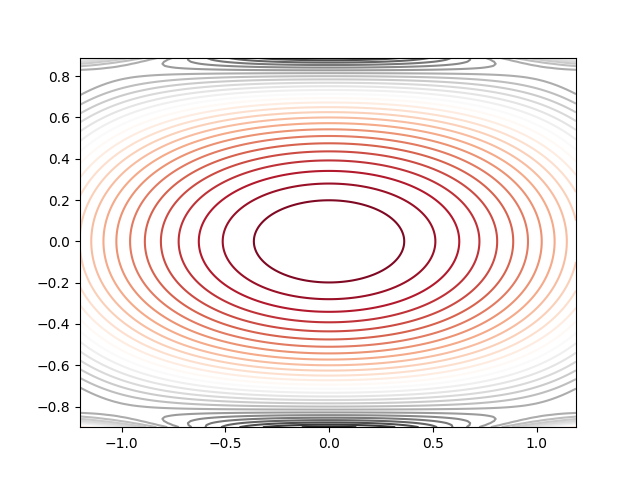

In [32]:
fig = plt.figure()
valx = 1.2
valpx = 0.9
xx = np.arange(-valx, valx, 0.01)
pxp = np.arange(-valpx, valpx, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),qd_hamf,"numpy")
H = ham(X, P)

plt.contour(X,P,H, 30, cmap='RdGy')
plt.show()

In [33]:
partialderiv_x= Derivative(qd_ham, x)
partialderiv_p= Derivative(qd_ham, px)
H_x = partialderiv_x.doit()
H_p = partialderiv_p.doit()

# Using the full drift Hamiltonian requires more computing power therefore takes much more time
# Should implement parallel computing i.e. run on all cores

x_FP = Eq(H_x, 0) # dH/dx = 0
p_FP = Eq(H_p, 0) # dH/dp = 0

# compute fixed points
fixed_points = solve( (x_FP, p_FP), x, px )
print(fixed_points)

{p_x: 0.0, x: 0.0}


In [34]:
partialderiv_x= Derivative(qd_hamf, x)
partialderiv_p= Derivative(qd_hamf, px)
H_x = partialderiv_x.doit()
H_p = partialderiv_p.doit()

# Using the full drift Hamiltonian requires more computing power therefore takes much more time
# Should implement parallel computing i.e. run on all cores

x_FP = Eq(H_x, 0) # dH/dx = 0
p_FP = Eq(H_p, 0) # dH/dp = 0

# compute fixed points
fixed_points = solve( (x_FP, p_FP), x, px )
print(fixed_points)

[(-1.00872383294860, -0.820004466892643), (-1.00872383294860, 0.820004466892643), (0.0, 0.0), (1.00872383294860, -0.820004466892643), (1.00872383294860, 0.820004466892643)]


# Example QF-D-QF

Let us apply this to an example, where we consider $A$ and $C$ to be quads and $B$ to be a drift space.
<img src="QDQ.png" alt = "test pic" style = "width:250px; height=900px;">

We confine ourselves to the $x-px$ plane and use thin lens approximations for the quadrupoles to not make things to complicated when the expressions are expanded. We also use the paraxial approximation for the Drift. The relevant Hamiltonians are then given by:
$$H_{Q_1}=\frac{L k_{Q1} x^{2}}{2} \\
H_{D}=\frac{L p_{x}^{2}}{2} \\
H_{Q_2}=L x^{2} \left(\frac{\delta{k_{Q1}}}{2} + \frac{k_{Q1}}{2}\right)
$$

In [35]:
from sympy import NumberSymbol

class SymbolTrick(NumberSymbol):
    """
    https://stackoverflow.com/questions/39665207/define-a-variable-in-sympy-to-be-a-constant
    """
    def __new__(self, name):
        obj = NumberSymbol.__new__(self)
        obj._name = name
        return obj
    __str__ = lambda self: str(self._name)
    _as_mpf_val = 1.0
    
    def _latex(self, printer, *args):
        return r"{}".format(self._name)

In [36]:
LQ = SymbolTrick("L_Q")
LD = SymbolTrick("L_D")
kq1 = SymbolTrick("K_{Q_1}")
dkq1 = SymbolTrick("\delta{K_{Q_1}}")

In [37]:
dkq1

In [38]:
# inserting replacements to ignore all planes besides x-px
rep = list(zip([delta, px, y, py],[0,0,0,0]))
hamq1 = HamQuad6DParaxialSecondOrder(beta0,gamma0,LQ,x,px,y,py,delta,kq1).subs(rep)
hamq2 = HamQuad6DParaxialSecondOrder(beta0,gamma0,LQ,x,px,y,py,delta,kq1+dkq1).subs(rep)
hamd  = HamDrift6DParaxialSecondOrder(beta0,gamma0,LD,x,px,y,py,delta).subs(delta,0).subs(py,0)

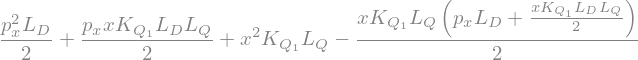

In [39]:
Aop.BCH(Bop,2).BCH(Aop,2).ham.subs(A,hamq1).subs(B,hamd).doit()

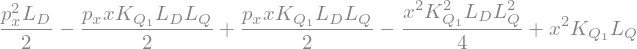

In [40]:
Aop.BCH(Bop,2).BCH(Aop,2).ham.subs(A,hamq1).subs(B,hamd).doit().expand()

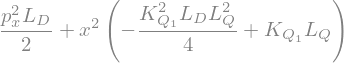

In [41]:
s_case = simplify(Aop.BCH(Bop,2).BCH(Aop,2).ham.subs(A,hamq1).subs(B,hamd).doit()).expand().collect(x**2)
s_case

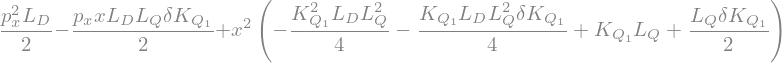

In [45]:
Aop.BCH(Bop,2).BCH(Cop,2).ham.subs(A,hamq1).subs(C,hamq2).subs(B,hamd).doit().expand().collect(x**2).collect(x*px)

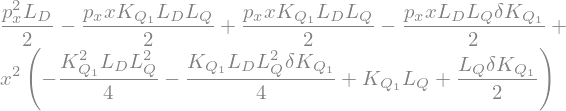

In [46]:
sb_case = Aop.BCH(Bop,2).BCH(Cop,2).ham.subs(A,hamq1).subs(C,hamq2).subs(B,hamd).doit().expand().collect(x**2)
sb_case

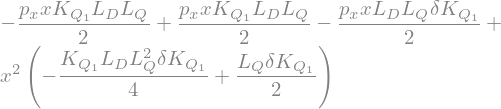

In [47]:
s_sb_diff = (sb_case-s_case).expand().collect(x**2)
s_sb_diff

In [48]:
Poly(s_sb_diff,x,px).coeff_monomial(x*px)

NameError: name 'Poly' is not defined

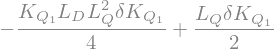

In [354]:
Poly(s_sb_diff,x,px).coeff_monomial(x*x)

In [49]:
k=1.5
lq = .25
ld = 2
dk = .1
nrep = list(zip([LD,LQ,kq1],[ld,lq,k]))
s_ham = s_case.subs(nrep)
sb_ham = sb_case.subs(nrep).subs(dkq1,dk)
s_ham, sb_ham

<IPython.core.display.Javascript object>


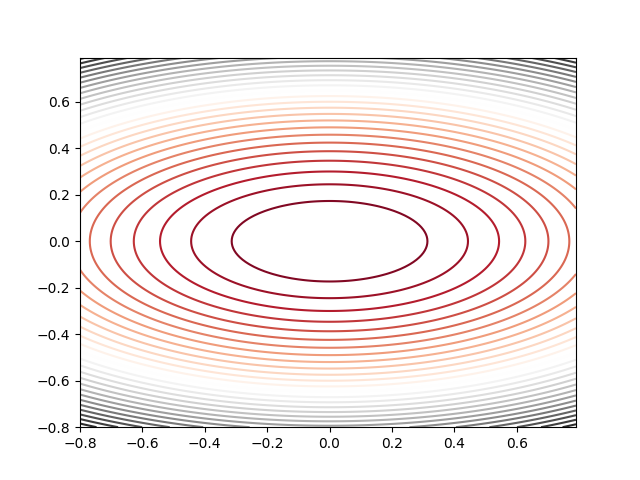

In [50]:
fig = plt.figure()
xx = np.arange(-0.8, 0.8, 0.01)
pxp = np.arange(-0.8, 0.8, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),s_ham,"numpy")
H = ham(X, P)

plt.contour(X,P,H, 30, cmap='RdGy')
plt.show()

<IPython.core.display.Javascript object>


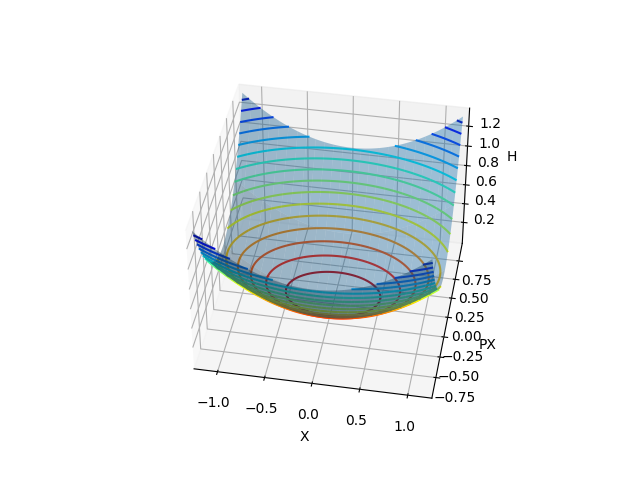

In [51]:

mg  = 50   # meshgrid size

fig = plt.figure()
ax = fig.gca(projection='3d')
valx = 1.2
valpx = 0.955
xx = np.arange(-valx, valx, 0.01)
pxp = np.arange(-valpx, valpx, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),s_ham,"numpy")
H = ham(X, P)

ax.plot_surface(X, P, H,alpha=0.4,rstride=mg)
cset = ax.contour(X, P, H,levels=20,cmap=cm.jet_r)
ax.clabel(cset, fontsize=9, inline=1)

ax.set_xlabel('X')
ax.set_xlim(-valx, valx)
ax.set_ylabel('PX')
ax.set_ylim(-valpx, valpx)
ax.set_zlabel('H')
#ax.set_zlim(-100, 100)
ax.view_init(elev=40., azim=-80)
plt.show()

<IPython.core.display.Javascript object>


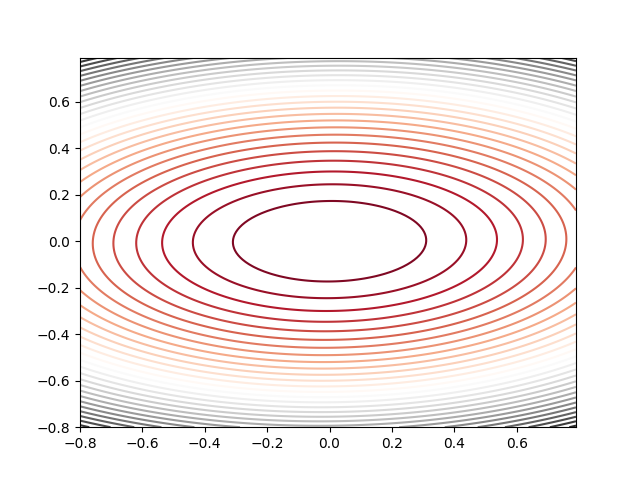

In [52]:
fig = plt.figure()
xx = np.arange(-0.8, 0.8, 0.01)
pxp = np.arange(-0.8, 0.8, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),sb_ham,"numpy")
H = ham(X, P)

plt.contour(X,P,H, 30, cmap='RdGy')
plt.show()

<IPython.core.display.Javascript object>


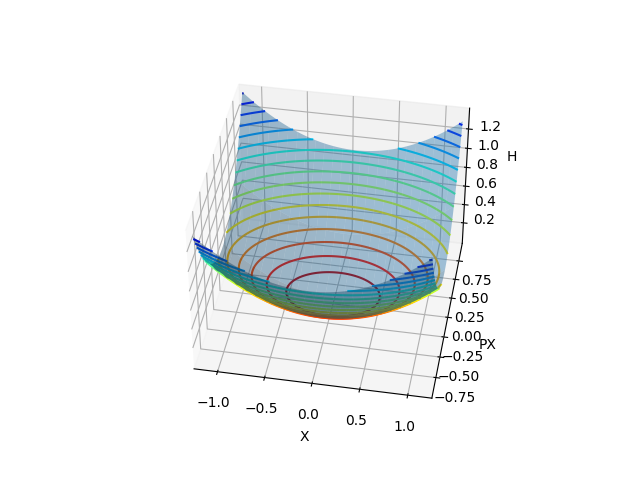

In [53]:

mg  = 50   # meshgrid size

fig = plt.figure()
ax = fig.gca(projection='3d')
valx = 1.2
valpx = 0.955
xx = np.arange(-valx, valx, 0.01)
pxp = np.arange(-valpx, valpx, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),sb_ham,"numpy")
H = ham(X, P)

ax.plot_surface(X, P, H,alpha=0.4,rstride=mg)
cset = ax.contour(X, P, H,levels=20,cmap=cm.jet_r)
ax.clabel(cset, fontsize=9, inline=1)

ax.set_xlabel('X')
ax.set_xlim(-valx, valx)
ax.set_ylabel('PX')
ax.set_ylim(-valpx, valpx)
ax.set_zlabel('H')
#ax.set_zlim(-100, 100)
ax.view_init(elev=40., azim=-80)
plt.show()

In [411]:
partialderiv_x= Derivative(s_ham, x)
partialderiv_p= Derivative(s_ham, px)
H_x = partialderiv_x.doit()
H_p = partialderiv_p.doit()

# Using the full drift Hamiltonian requires more computing power therefore takes much more time
# Should implement parallel computing i.e. run on all cores

x_FP = Eq(H_x, 0) # dH/dx = 0
p_FP = Eq(H_p, 0) # dH/dp = 0

# compute fixed points
fixed_points = solve( (x_FP, p_FP), x, px )
print(fixed_points)

{p_x: 0.0, x: 0.0}


In [412]:
partialderiv_x= Derivative(sb_ham, x)
partialderiv_p= Derivative(sb_ham, px)
H_x = partialderiv_x.doit()
H_p = partialderiv_p.doit()

# Using the full drift Hamiltonian requires more computing power therefore takes much more time
# Should implement parallel computing i.e. run on all cores

x_FP = Eq(H_x, 0) # dH/dx = 0
p_FP = Eq(H_p, 0) # dH/dp = 0

# compute fixed points
fixed_points = solve( (x_FP, p_FP), x, px )
print(fixed_points)

{p_x: 0.0, x: 0.0}


# Using full hamiltonian for drift

In [54]:
rep = list(zip([delta, px, y, py],[0,0,0,0]))
hamq1 = HamQuad6DParaxialSecondOrder(beta0,gamma0,LQ,x,px,y,py,delta,kq1).subs(rep)
hamq2 = HamQuad6DParaxialSecondOrder(beta0,gamma0,LQ,x,px,y,py,delta,kq1+dkq1).subs(rep)
hamd  = HamDrift6D(beta0,gamma0,LD,x,px,y,py,delta).subs(delta,0).subs(py,0).subs(beta0*gamma0,oo).subs(beta0,1)
hamd

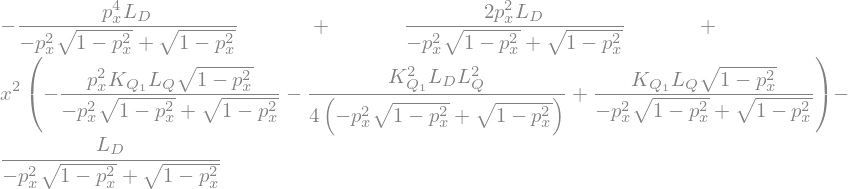

In [55]:
s_casef = simplify(Aop.BCH(Bop,2).BCH(Aop,2).ham.subs(A,hamq1).subs(B,hamd).doit()).expand().collect(x**2)
s_casef

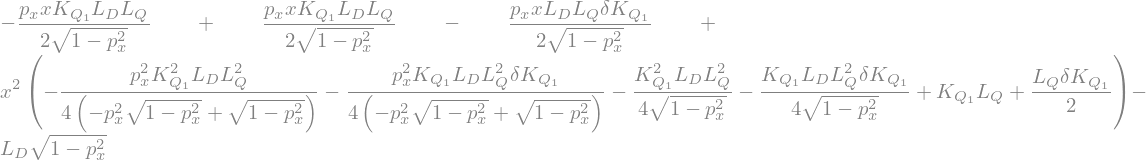

In [57]:
sb_casef = Aop.BCH(Bop,2).BCH(Cop,2).ham.subs(A,hamq1).subs(C,hamq2).subs(B,hamd).doit().expand().collect(x**2)
sb_casef

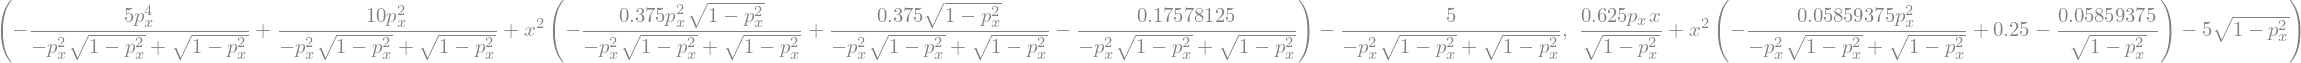

In [86]:
k=1.5
lq = .25
ld = 5
dk = -1.
nrep = list(zip([LD,LQ,kq1],[ld,lq,k]))
s_hamf = s_casef.subs(nrep)
sb_hamf = sb_casef.subs(nrep).subs(dkq1,dk)
s_hamf, sb_hamf

<IPython.core.display.Javascript object>


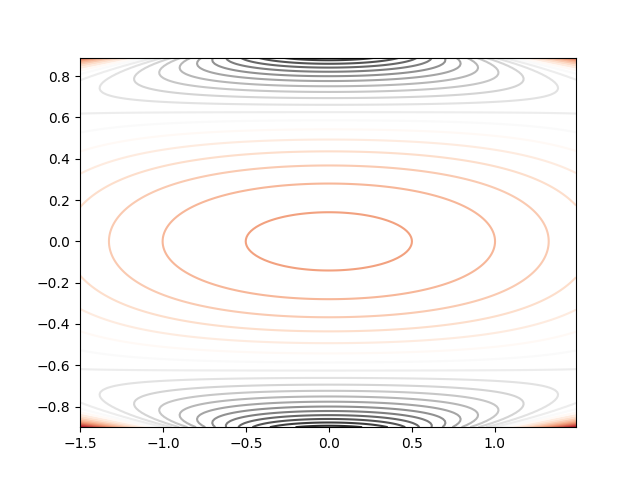

In [87]:
fig = plt.figure()
xx = np.arange(-1.5, 1.5, 0.01)
pxp = np.arange(-0.9, 0.9, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),s_hamf,"numpy")
H = ham(X, P)

plt.contour(X,P,H, 30, cmap='RdGy')
plt.show()

<IPython.core.display.Javascript object>


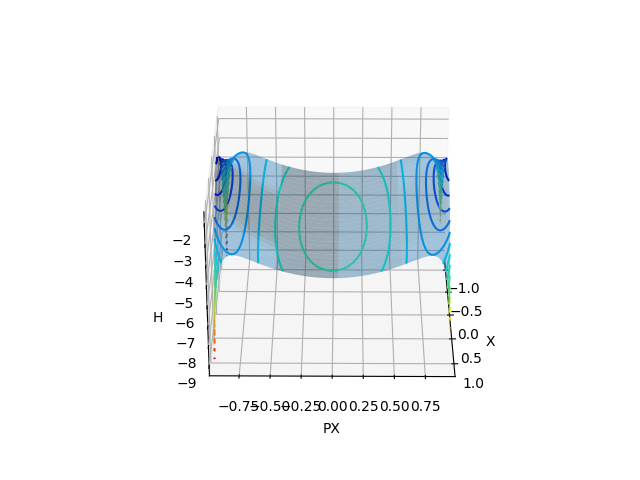

In [92]:
mg  = 50   # meshgrid size

fig = plt.figure()
ax = fig.gca(projection='3d')
valx = 1.2
valpx = 0.95
xx = np.arange(-valx, valx, 0.01)
pxp = np.arange(-valpx, valpx, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),s_hamf,"numpy")
H = ham(X, P)

ax.plot_surface(X, P, H,alpha=0.4,rstride=mg)
cset = ax.contour(X, P, H,levels=20,cmap=cm.jet_r)
ax.clabel(cset, fontsize=9, inline=1)

ax.set_xlabel('X')
ax.set_xlim(-valx, valx)
ax.set_ylabel('PX')
ax.set_ylim(-valpx, valpx)
ax.set_zlabel('H')
#ax.set_zlim(-100, 100)
ax.view_init(elev=40., azim=-80)
plt.show()

<IPython.core.display.Javascript object>


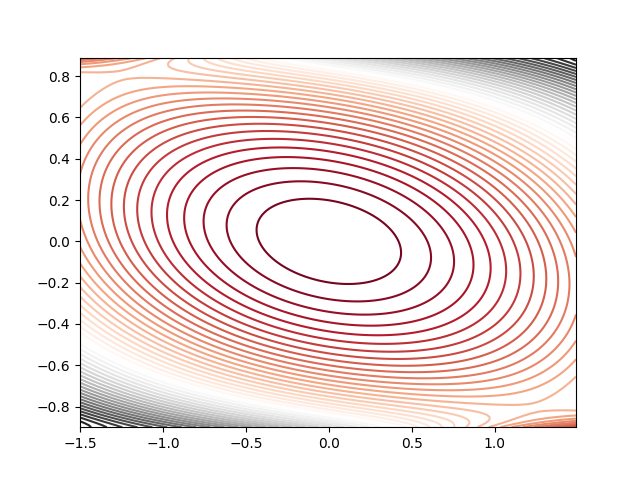

In [61]:
fig = plt.figure()
xx = np.arange(-1.5, 1.5, 0.01)
pxp = np.arange(-0.9, 0.9, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),sb_hamf,"numpy")
H = ham(X, P)

plt.contour(X,P,H, 50, cmap='RdGy')
plt.show()

<IPython.core.display.Javascript object>


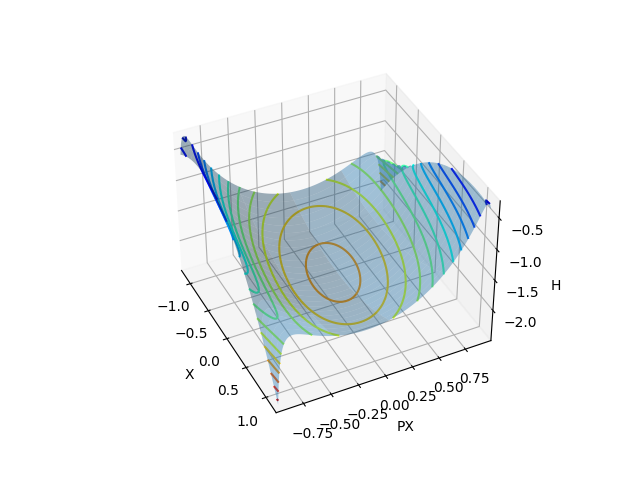

In [62]:
mg  = 50   # meshgrid size

fig = plt.figure()
ax = fig.gca(projection='3d')
valx = 1.2
valpx = 0.955
xx = np.arange(-valx, valx, 0.01)
pxp = np.arange(-valpx, valpx, 0.01)
X, P = np.meshgrid(xx, pxp)
ham = lambdify((x,px),sb_hamf,"numpy")
H = ham(X, P)

ax.plot_surface(X, P, H,alpha=0.4,rstride=mg)
cset = ax.contour(X, P, H,levels=20,cmap=cm.jet_r)
ax.clabel(cset, fontsize=9, inline=1)

ax.set_xlabel('X')
ax.set_xlim(-valx, valx)
ax.set_ylabel('PX')
ax.set_ylim(-valpx, valpx)
ax.set_zlabel('H')
#ax.set_zlim(-100, 100)
ax.view_init(elev=40., azim=-80)
plt.show()

In [63]:
partialderiv_x= Derivative(s_hamf, x)
partialderiv_p= Derivative(s_hamf, px)
H_x = partialderiv_x.doit()
H_p = partialderiv_p.doit()

# Using the full drift Hamiltonian requires more computing power therefore takes much more time
# Should implement parallel computing i.e. run on all cores

x_FP = Eq(H_x, 0) # dH/dx = 0
p_FP = Eq(H_p, 0) # dH/dp = 0

# compute fixed points
fixed_points = solve( (x_FP, p_FP), x, px )
print(fixed_points)

[(-1.00872383294860, -0.820004466892643), (-1.00872383294860, 0.820004466892643), (0.0, 0.0), (1.00872383294860, -0.820004466892643), (1.00872383294860, 0.820004466892643)]


In [64]:
partialderiv_x= Derivative(sb_hamf, x)
partialderiv_p= Derivative(sb_hamf, px)
H_x = partialderiv_x.doit()
H_p = partialderiv_p.doit()

# Using the full drift Hamiltonian requires more computing power therefore takes much more time
# Should implement parallel computing i.e. run on all cores

x_FP = Eq(H_x, 0) # dH/dx = 0
p_FP = Eq(H_p, 0) # dH/dp = 0

# compute fixed points
fixed_points = solve( (x_FP, p_FP), x, px )
print(fixed_points)

[]


In [77]:
from scipy.optimize import fsolve
fxfp = lambdify((x,px),H_x,"numpy")
fpfp = lambdify((x,px),H_p,"numpy")
def func(m):
    return [fxfp(m[0],m[1]),fpfp(m[0],m[1])]
    
fsolve(func,[0.9,-0.8]), fsolve(func,[-.9,.8])

(array([ 1.24721735, -0.80640616]), array([-1.24721735,  0.80640616]))

In [66]:
solve( (x_FP, p_FP), x, px )

# Generating plots

In [47]:
lattice = {
    "Q1": {
        "l" : 0.25,
        "class": "QUADRUPOLE",
        "k1": 1.5,
        "k2": 0.0,
        "angle": 0.0,
        "center pos": 0.125
    },
    "D": {
        "l" : 5.0,
        "class": "DRIFT",
        "k1": 0.0,
        "k2": 0.0,
        "angle": 0.0,
        "center pos": 2.75
    },
    "Q2": {
        "l" : 0.25,
        "class": "QUADRUPOLE",
        "k1": 1.5,
        "k2": 0.0,
        "angle": 0.0,
        "center pos": 5.375
    },
    
}

In [33]:
lattice = pd.DataFrame(
    {
        "class" : ["QUADRUPOLE", "DRIFT", "QUADRUPOLE"],
        "NAME" : ["Q1","D","Q2"],
        "l":        [0.25,5,0.25],
        "k1":      [1.5, 0, 1.5]
        
    }
)
lattice["end_pos"] = lattice['l'].cumsum()
lattice["at"] = lattice['end_pos']- lattice['l']/2
lattice

class NAME     l   k1  end_pos     at
0  QUADRUPOLE   Q1  0.25  1.5     0.25  0.125
1       DRIFT    D  5.00  0.0     5.25  2.750
2  QUADRUPOLE   Q2  0.25  1.5     5.50  5.375

In [34]:
from AcceleratorPlotTools.AcceleratorPlotTools import plot_lattice

<IPython.core.display.Javascript object>


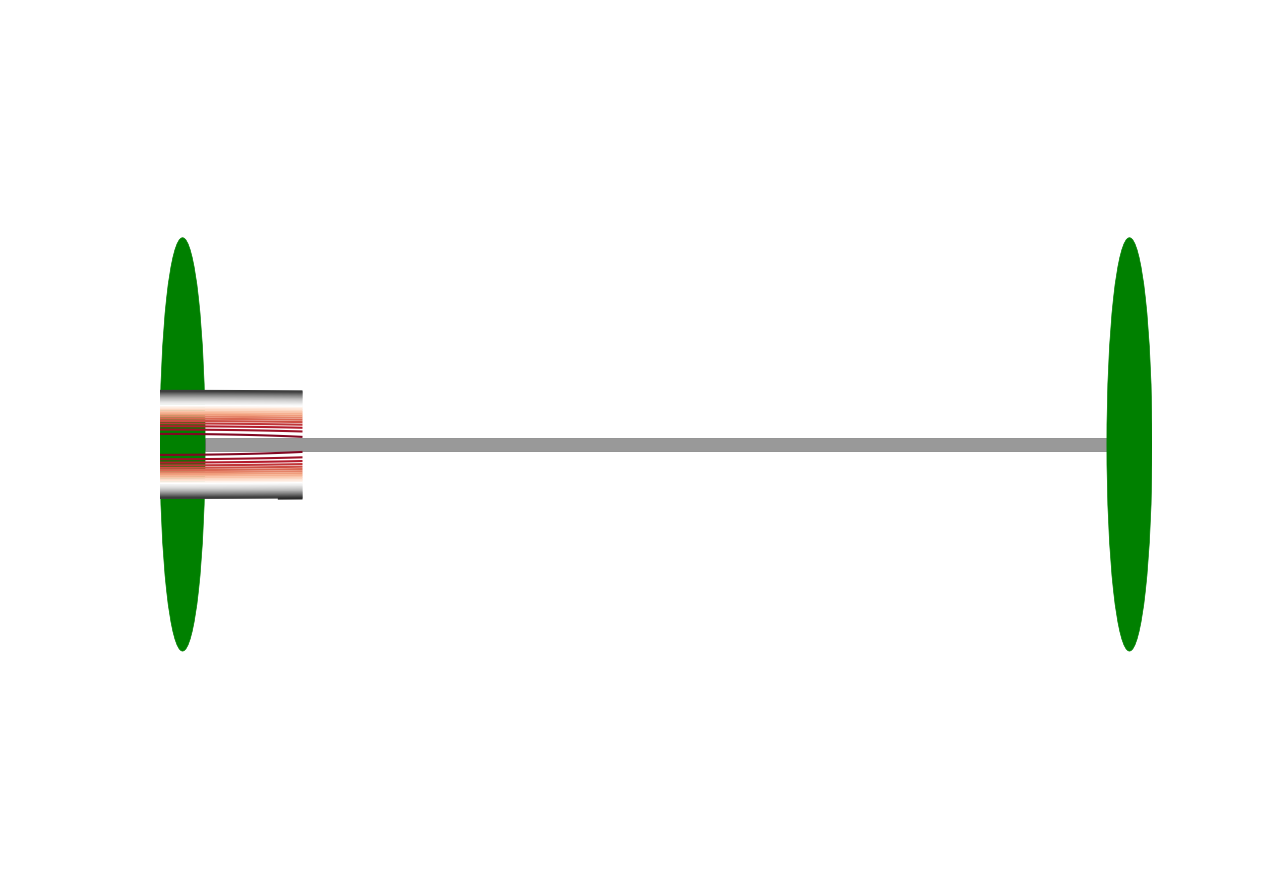

Q1          ,  0.2500,  0.2500,QUADRUPOLE  
D           ,  5.2500,  5.0000,DRIFT       
Q2          ,  5.5000,  0.2500,QUADRUPOLE  


In [69]:
plot_lattice(lattice, params={"kmax": .5, "ang_max": 1.5e-2, "smax": 10.0})
plt.grid(False)
plt.axis("Off")
plt.savefig("QDQ.png")

fig

<IPython.core.display.Javascript object>


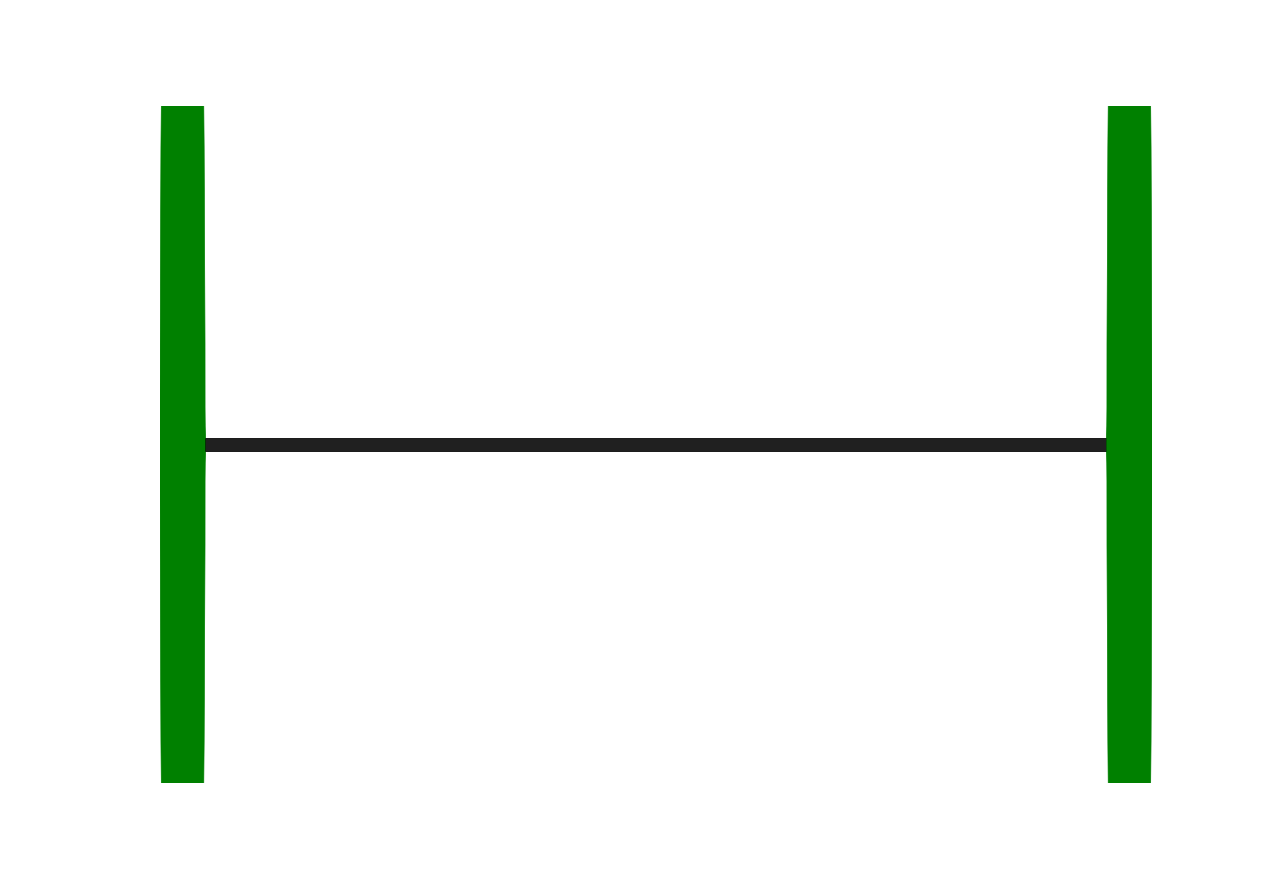

In [61]:
fig

We  start by considering the following lattice:
$$A-B-C-D-E$$
where A,B,C,D,E are generic lattice elements and we consider the beam coming from the left (this important for the ordering of the operators).

The corresponding Lie map is given by:
$$e^{A}e^{B}e^{C}e^{D}e^{E}$$
and after the correct coordinate transformations this becomes:
$$e^{E}e^{D}e^{C}e^{B}e^{A}$$

The operators A,..,E in the exponents need to be combined using the BCH formula. Doing this order by order, where with order we mean the number of iterative Poisson brackets and not the order of the resulting polynomial in the independent coordinates, we get:
$$H_0 = A +B + C + D + E$$

For the higher orders we go step by step. Let us start by first having a look at $H_1$ for the first three elements.

In [ ]:

xval = 2.0
pval = 0.9
npoints =100
mg = 50

X = np.linspace(-xval, xval, npoints)
P = np.linspace(-pval, pval, npoints)

n=21 #number of energy levels to show +1 

color=cm.jet(np.linspace(1,0,n))

# subplot grid
fig = plt.figure(constrained_layout=True, figsize = (10,6))
gs  = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:], projection = "3d")

ax1.plot(X, Potentialnp1DHarmonicOscillator(X,mass,om),linewidth=2,c="black")
ax1.hlines(range(n),-2,2,colors=color)
ax1.set_xlabel(r"$x$",fontsize =12);
ax1.set_ylabel(r"$V(x)$",fontsize=12);
ax1.set_title("Potential Harmonic Oscillator with Energy Levels");

X = np.linspace(-xval, xval, npoints)
P = np.linspace(-3*pval, 3*pval, npoints)
Xg, Pg = np.meshgrid(X, P)
H = Hamnp1DHarmonicOscillator(Xg,Pg,mass,om)
ax2.contour(Xg, Pg, H, mg)
ax2.set_xlabel(r"$x$",fontsize =12);
ax2.set_ylabel(r"$p_x$",fontsize=12);
ax2.set_title("Harmonic Oscillator - Hamiltonian Levels");


ax3.plot_surface(Xg, Pg, H,alpha=0.4,rstride=mg)
ax3 = fig.gca(projection='3d')
cset = ax3.contour(X, P, H,levels=20,cmap=cm.jet_r)
ax3.clabel(cset, fontsize=9, inline=1)
ax3.set_xlabel(r"$x$",fontsize =12);
ax3.set_ylabel(r"$p_x$",fontsize=12);
ax3.set_zlabel(r"$H(x,p_x)$",fontsize=12);
ax3.set_title("Harmonic Oscillator - Hamiltonian surface and levels")